In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [2]:
import tensorflow as tf

# Ref: https://www.tensorflow.org/guide/gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [3]:
df = pd.read_csv('data/base_data_8Y.csv')

In [4]:
df = df.dropna().copy()
#df['target'] = df['spy_oc_ret'].shift(-1)
#df = df.dropna()

df.index = df['datecol']
df

,spy_oc_ret,spy_pco_ret,spy_volume,spy_volatility_atr,spy_trend_ichimoku_conv,spy_trend_ichimoku_base,spy_trend_ichimoku_a,spy_trend_ichimoku_b,spy_trend_cci,spy_momentum_rsi,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
datecol,,,,,,,,,,,,,,,,,,,,,
2015-01-30,-0.558409,-0.703005,1422361,3.143214,202.47,203.760,203.1150,205.415,-98.111841,41.538888,...,0,0,0,0,0,0,0,0,0,0
2015-02-02,0.929721,0.305841,1314424,3.245892,202.06,203.415,202.7375,205.415,-76.015134,47.585237,...,0,0,0,0,0,0,0,0,0,0
2015-02-03,0.906404,0.534865,1035204,3.214303,202.06,203.415,202.7375,205.415,68.015623,53.683827,...,0,0,0,0,0,0,0,0,0,0
2015-02-04,0.068654,-0.449131,1059156,3.079873,201.98,203.415,202.6975,205.415,70.575756,51.945157,...,0,0,0,0,0,0,0,0,0,0
2015-02-05,0.615054,0.392042,778565,2.995885,202.08,203.115,202.5975,205.415,113.473729,55.998374,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-02,1.160998,-1.261721,513953,6.523936,401.33,389.395,395.3625,379.055,109.592125,62.875939,...,0,0,0,0,0,0,0,0,0,1
2022-12-05,-1.079342,-0.727434,501248,6.745542,401.65,389.395,395.5225,379.055,61.395549,55.317131,...,0,0,0,0,0,0,0,0,0,1
2022-12-06,-1.399529,-0.042544,562006,6.905988,400.82,389.395,395.1075,379.055,-17.096376,50.202757,...,0,0,0,0,0,0,0,0,0,1


In [5]:
df1 = df.copy()

In [6]:
df.columns

Index(['spy_oc_ret', 'spy_pco_ret', 'spy_volume', 'spy_volatility_atr',
       'spy_trend_ichimoku_conv', 'spy_trend_ichimoku_base',
       'spy_trend_ichimoku_a', 'spy_trend_ichimoku_b', 'spy_trend_cci',
       'spy_momentum_rsi',
       ...
       'month3', 'month4', 'month5', 'month6', 'month7', 'month8', 'month9',
       'month10', 'month11', 'month12'],
      dtype='object', length=136)

In [7]:

step_size = 20
mldf = pd.DataFrame()

df = df.drop(['datecol', 'trade_date'], axis=1)
df = df.reset_index(drop=True)

for i, row in df.iterrows():
    #print(row['date'])
    if i > step_size:
        tmp1 = df.iloc[i,:].copy().reset_index(drop = True)
        test = pd.DataFrame(tmp1)
        test_T = test.T.reset_index(drop = True)
        test_T.columns = df.columns


        for k in range(1,step_size):  # from 0 to 2
            tmp = df.iloc[i-k,:].copy().reset_index(drop = True)    # from 3-0, 3-1, 3-2
            test1 = pd.DataFrame(tmp)
            test1_T = test1.T.reset_index(drop = True)
            test1_T.columns = df.columns
            suffix_col = '_' + str(step_size-k)
            test1_T = test1_T.add_suffix(suffix_col)
            test_T = pd.concat([test_T,test1_T],axis=1)
        
        mldf = pd.concat([mldf,test_T],axis = 0)




In [8]:
mldf.shape

(1944, 2680)

In [9]:
mldf[['spy_bull','spy_bear','spy_neutral']]

,spy_bull,spy_bear,spy_neutral
0,0.0,0.0,1.0
0,0.0,1.0,0.0
0,1.0,0.0,0.0
0,0.0,1.0,0.0
0,0.0,0.0,1.0
...,...,...,...
0,0.0,1.0,0.0
0,0.0,1.0,0.0
0,0.0,1.0,0.0
0,0.0,1.0,0.0


In [10]:
mldf = mldf.dropna()
mldf

mldf['target_1'] = mldf['spy_bull'].shift(-1)
mldf['target_2'] = mldf['spy_bear'].shift(-1)
mldf['target_3'] = mldf['spy_neutral'].shift(-1)

mldf = mldf.dropna()
mldf

,spy_oc_ret,spy_pco_ret,spy_volume,spy_volatility_atr,spy_trend_ichimoku_conv,spy_trend_ichimoku_base,spy_trend_ichimoku_a,spy_trend_ichimoku_b,spy_trend_cci,spy_momentum_rsi,...,month6_1,month7_1,month8_1,month9_1,month10_1,month11_1,month12_1,target_1,target_2,target_3
0,-0.165508,-0.245295,825307.0,1.669605,210.485,205.050,207.7675,205.415,61.959043,60.817866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,-0.080798,-0.341038,823814.0,1.708645,210.485,205.050,207.7675,205.415,28.466826,56.898993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,-0.075966,0.185511,603513.0,1.632780,210.650,205.050,207.8500,205.415,38.230788,57.658306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,-0.916818,-0.494156,1179812.0,1.805502,209.670,205.050,207.3600,205.050,-52.094807,46.343006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.298450,0.115663,695836.0,1.753952,209.670,205.050,207.3600,205.050,-59.867129,49.447146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.347358,0.274725,530326.0,6.613262,401.330,389.395,395.3625,379.055,122.555934,63.392394,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
0,1.160998,-1.261721,513953.0,6.523936,401.330,389.395,395.3625,379.055,109.592125,62.875939,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
0,-1.079342,-0.727434,501248.0,6.745542,401.650,389.395,395.5225,379.055,61.395549,55.317131,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
0,-1.399529,-0.042544,562006.0,6.905988,400.820,389.395,395.1075,379.055,-17.096376,50.202757,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
mldf.columns

Index(['spy_oc_ret', 'spy_pco_ret', 'spy_volume', 'spy_volatility_atr',
       'spy_trend_ichimoku_conv', 'spy_trend_ichimoku_base',
       'spy_trend_ichimoku_a', 'spy_trend_ichimoku_b', 'spy_trend_cci',
       'spy_momentum_rsi',
       ...
       'month6_1', 'month7_1', 'month8_1', 'month9_1', 'month10_1',
       'month11_1', 'month12_1', 'target_1', 'target_2', 'target_3'],
      dtype='object', length=2683)

In [12]:
mldf = mldf.astype(float)
mldf.dtypes

spy_oc_ret                 float64
spy_pco_ret                float64
spy_volume                 float64
spy_volatility_atr         float64
spy_trend_ichimoku_conv    float64
                            ...   
month11_1                  float64
month12_1                  float64
target_1                   float64
target_2                   float64
target_3                   float64
Length: 2683, dtype: object

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [14]:
mldf.to_csv('data/20days_supervised.csv',index=False)

In [15]:
#reframed = series_to_supervised(df, 1, 1)

In [16]:
#reframed

In [17]:
#df.shape

In [18]:
#df.columns

In [19]:


#df = df.drop(['trade_date','datecol'],axis=1)


In [20]:
values = mldf.values

scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled = scaler.fit_transform(values)

values = scaled

n_train_time = 2500
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(1943, 1, 2682) (1943,) (0, 1, 2682) (0,)


In [21]:
train_X.shape[2]

2682

Epoch 1/200
7/7 - 1s - loss: 0.9006 - 1s/epoch - 203ms/step
Epoch 2/200
7/7 - 0s - loss: 0.2428 - 93ms/epoch - 13ms/step
Epoch 3/200
7/7 - 0s - loss: 0.2223 - 90ms/epoch - 13ms/step
Epoch 4/200
7/7 - 0s - loss: 0.2206 - 86ms/epoch - 12ms/step
Epoch 5/200
7/7 - 0s - loss: 0.2187 - 88ms/epoch - 13ms/step
Epoch 6/200
7/7 - 0s - loss: 0.2148 - 88ms/epoch - 13ms/step
Epoch 7/200
7/7 - 0s - loss: 0.2058 - 88ms/epoch - 13ms/step
Epoch 8/200
7/7 - 0s - loss: 0.1960 - 88ms/epoch - 13ms/step
Epoch 9/200
7/7 - 0s - loss: 0.1893 - 89ms/epoch - 13ms/step
Epoch 10/200
7/7 - 0s - loss: 0.1874 - 87ms/epoch - 12ms/step
Epoch 11/200
7/7 - 0s - loss: 0.1862 - 89ms/epoch - 13ms/step
Epoch 12/200
7/7 - 0s - loss: 0.1845 - 89ms/epoch - 13ms/step
Epoch 13/200
7/7 - 0s - loss: 0.1836 - 90ms/epoch - 13ms/step
Epoch 14/200
7/7 - 0s - loss: 0.1842 - 88ms/epoch - 13ms/step
Epoch 15/200
7/7 - 0s - loss: 0.1834 - 93ms/epoch - 13ms/step
Epoch 16/200
7/7 - 0s - loss: 0.1817 - 94ms/epoch - 13ms/step
Epoch 17/200
7/7 -

Epoch 133/200
7/7 - 0s - loss: 0.1715 - 88ms/epoch - 13ms/step
Epoch 134/200
7/7 - 0s - loss: 0.1714 - 89ms/epoch - 13ms/step
Epoch 135/200
7/7 - 0s - loss: 0.1702 - 101ms/epoch - 14ms/step
Epoch 136/200
7/7 - 0s - loss: 0.1694 - 94ms/epoch - 13ms/step
Epoch 137/200
7/7 - 0s - loss: 0.1686 - 87ms/epoch - 12ms/step
Epoch 138/200
7/7 - 0s - loss: 0.1678 - 97ms/epoch - 14ms/step
Epoch 139/200
7/7 - 0s - loss: 0.1670 - 87ms/epoch - 12ms/step
Epoch 140/200
7/7 - 0s - loss: 0.1658 - 96ms/epoch - 14ms/step
Epoch 141/200
7/7 - 0s - loss: 0.1651 - 100ms/epoch - 14ms/step
Epoch 142/200
7/7 - 0s - loss: 0.1655 - 97ms/epoch - 14ms/step
Epoch 143/200
7/7 - 0s - loss: 0.1629 - 95ms/epoch - 14ms/step
Epoch 144/200
7/7 - 0s - loss: 0.1628 - 87ms/epoch - 12ms/step
Epoch 145/200
7/7 - 0s - loss: 0.1628 - 89ms/epoch - 13ms/step
Epoch 146/200
7/7 - 0s - loss: 0.1622 - 87ms/epoch - 12ms/step
Epoch 147/200
7/7 - 0s - loss: 0.1584 - 85ms/epoch - 12ms/step
Epoch 148/200
7/7 - 0s - loss: 0.1627 - 84ms/epoch - 

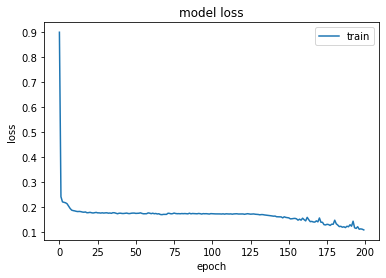

In [25]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=300, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()




In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], train_X.shape[2]))

'''
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -train_X.shape[2]+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

'''

test_y = test_y.reshape((len(test_y), 1))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -train_X.shape[2]:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -train_X.shape[2]:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
np.shape(test_X)

In [ ]:
np.shape(test_y)


In [ ]:
df

In [ ]:
import keras 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers